<a href="https://colab.research.google.com/github/sdariza/MLP-Weather-Prediction/blob/master/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iris-grib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 120.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.1/518.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/pressure/air.2023.nc'

--2023-06-07 14:10:41--  https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/pressure/air.2023.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132664525 (127M) [application/x-netcdf]
Saving to: ‘air.2023.nc’

air.2023.nc         100%[===================>] 126.52M  36.3MB/s    in 3.9s    

2023-06-07 14:10:45 (32.7 MB/s) - ‘air.2023.nc’ saved [132664525/132664525]



# Iris

In [67]:
import iris
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [4]:
cube = iris.load_cube('air.2023.nc')
cube

<iris 'Cube' of air_temperature / (degK) (time: 604; Level: 17; latitude: 73; longitude: 144)>

In [8]:
iris.Constraint?

In [23]:
query = iris.Constraint(Level = lambda cell : cell ==1000,
                        time = lambda cell : cell.point.hour == 0,
                        coord_values={'latitude': lambda cell : cell in [90, 87.5],
                                      'longitude': lambda cell: cell in [357.5, 0, 2.5]}
                        )
H0 = cube.extract(query)
H0

<iris 'Cube' of air_temperature / (degK) (time: 151; latitude: 2; longitude: 3)>

In [29]:
H0.coord('latitude').points

array([90. , 87.5], dtype=float32)

In [30]:
H0.coord('longitude').points

array([  0. ,   2.5, 357.5], dtype=float32)

In [48]:
query = iris.Constraint(Level = lambda cell : cell ==1000,
                        time = lambda cell : cell.point.hour == 6,
                        coord_values={'latitude': lambda cell : cell in [90],
                                      'longitude': lambda cell: cell in [0]}
                        )
H6 = cube.extract(query)
H6

Air Temperature (degK),time
Shape,151
Dimension coordinates,
time,x
Scalar coordinates,
Level,1000.0 millibar
latitude,90.0 degrees
longitude,0.0 degrees
Attributes,
Conventions,'CF-1.0'
GRIB_id,11


In [49]:
X = H0.data.data
y = H6.data.data

In [50]:
y.shape

(151,)

In [51]:
df = pd.DataFrame(np.reshape(X,newshape=(len(X), 3*2)), columns = [f'x{i}' for i in range(6)])
df['y'] = y
df

,x0,x1,x2,x3,x4,x5,y
0,250.000000,250.000000,250.000000,257.100006,257.200012,256.899994,249.000000
1,250.000000,250.000000,250.000000,253.600006,253.800003,253.400009,250.199997
2,252.399994,252.399994,252.399994,256.299988,256.500000,256.100006,251.900009
3,253.899994,253.899994,253.899994,259.000000,258.899994,259.000000,254.699997
4,260.000000,260.000000,260.000000,262.899994,262.899994,263.000000,260.399994
...,...,...,...,...,...,...,...
146,266.100006,266.100006,266.100006,263.399994,263.399994,263.500000,265.899994
147,264.299988,264.299988,264.299988,265.199982,265.100006,265.399994,265.300018
148,267.100006,267.100006,267.100006,268.699982,268.600006,268.799988,268.000000
149,270.299988,270.299988,270.299988,268.199982,268.100006,268.299988,270.200012


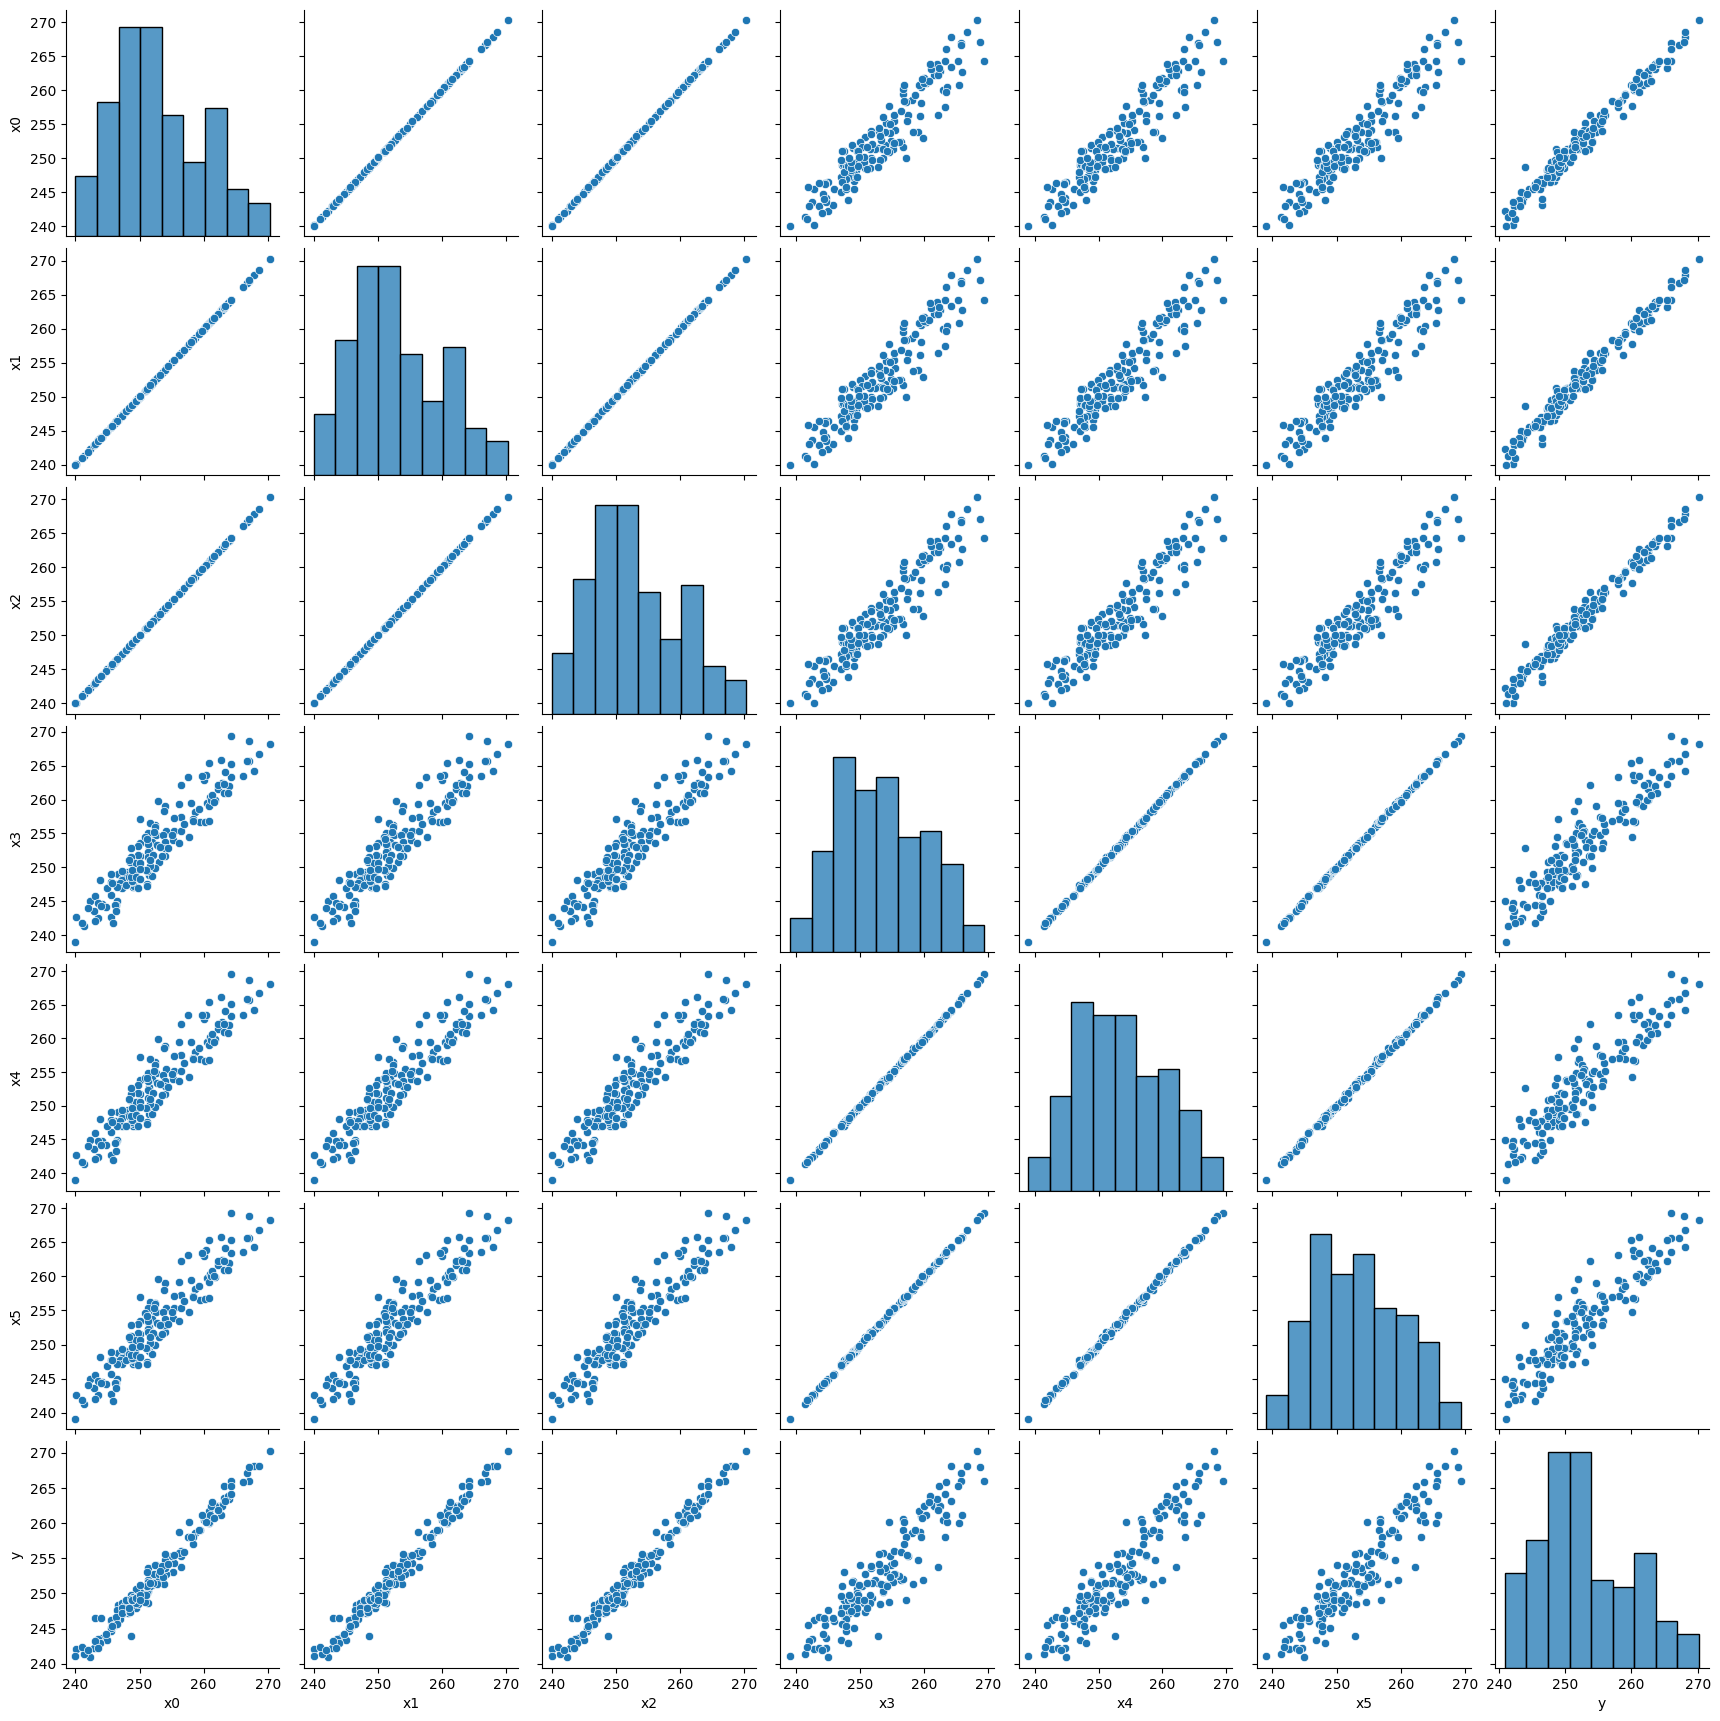

In [52]:
sns.pairplot(df)

<Axes: >

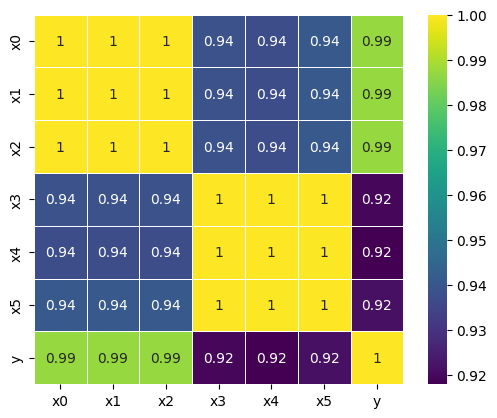

In [53]:
sns.heatmap(df.corr(), square=True, linewidths=.5, annot=True, cmap='viridis')

In [61]:
X = df.drop(columns=['y']).to_numpy()
y = df['y'].to_numpy()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123, train_size=.1)

In [63]:
model = MLPRegressor(hidden_layer_sizes=(7),max_iter=300, solver='adam' ,verbose=True, random_state=123, early_stopping=True)

In [64]:
model.fit(X=X_train, y=y_train)

Iteration 1, loss = 40884.19142590
Validation score: -936.519157
Iteration 2, loss = 40310.38283210
Validation score: -923.255920
Iteration 3, loss = 39738.96486331
Validation score: -910.050233
Iteration 4, loss = 39170.03517577
Validation score: -896.903758
Iteration 5, loss = 38603.66017573
Validation score: -883.817834
Iteration 6, loss = 38039.91017568
Validation score: -870.794907
Iteration 7, loss = 37478.87111314
Validation score: -857.835991
Iteration 8, loss = 36920.60939435
Validation score: -844.943072
Iteration 9, loss = 36365.19142556
Validation score: -832.117672
Iteration 10, loss = 35812.69533176
Validation score: -819.361453
Iteration 11, loss = 35263.18751922
Validation score: -806.675799
Iteration 12, loss = 34716.73439418
Validation score: -794.062395
Iteration 13, loss = 34173.39845664
Validation score: -781.522672
Iteration 14, loss = 33633.24611285
Validation score: -769.057967
Iteration 15, loss = 33096.33595656
Validation score: -756.669874
Iteration 16, loss 

MLPRegressor(early_stopping=True, hidden_layer_sizes=7, max_iter=300,
             random_state=123, verbose=True)

In [66]:
print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')

MAE: 1.4026124477386475


In [68]:
print(f'MAPE: {mean_absolute_percentage_error(y_test, model.predict(X_test))}')

MAPE: 0.00554994959384203


# Xarray

In [ ]:
import xarray as xr
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
data = xr.open_dataset('air.2023.nc')
data

<xarray.Dataset>
Dimensions:  (level: 17, lat: 73, lon: 144, time: 604)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-05-31T18:00:00
Data variables:
    air      (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [ ]:
data.sel(level=1000, lat = slice(90,87.5), lon=slice(0,5), time=data['time.hour']==0)

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 3, time: 151)
Coordinates:
    level    float32 1e+03
  * lat      (lat) float32 90.0 87.5
  * lon      (lon) float32 0.0 2.5 5.0
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-05-31
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [ ]:
r1 = data.sel(level=1000, lat = slice(90,87.5), lon=slice(0,2.5), time=data['time.hour']==0)
r2 = data.sel(level=1000, lat = slice(90,87.5), lon=slice(357.5, 360), time=data['time.hour']==0)
X = xr.concat([r1, r2], dim='lon')
X

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 3, time: 151)
Coordinates:
    level    float32 1e+03
  * lat      (lat) float32 90.0 87.5
  * lon      (lon) float32 0.0 2.5 357.5
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-05-31
Data variables:
    air      (time, lat, lon) float32 250.0 250.0 250.0 ... 266.7 266.7 266.8
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [ ]:
y = data.sel(level=1000, lat = 90, lon=0, time=data['time.hour']==6)['air'].data

In [ ]:
X['air'].values.shape

(151, 2, 3)

In [ ]:
df = pd.DataFrame(np.reshape(X['air'].data, newshape=(151,6)))
df['y'] = y
df

,0,1,2,3,4,5,y
0,250.000000,250.000000,250.000000,257.100006,257.200012,256.899994,249.000000
1,250.000000,250.000000,250.000000,253.600006,253.800003,253.400009,250.199997
2,252.399994,252.399994,252.399994,256.299988,256.500000,256.100006,251.900009
3,253.899994,253.899994,253.899994,259.000000,258.899994,259.000000,254.699997
4,260.000000,260.000000,260.000000,262.899994,262.899994,263.000000,260.399994
...,...,...,...,...,...,...,...
146,266.100006,266.100006,266.100006,263.399994,263.399994,263.500000,265.899994
147,264.299988,264.299988,264.299988,265.199982,265.100006,265.399994,265.300018
148,267.100006,267.100006,267.100006,268.699982,268.600006,268.799988,268.000000
149,270.299988,270.299988,270.299988,268.199982,268.100006,268.299988,270.200012


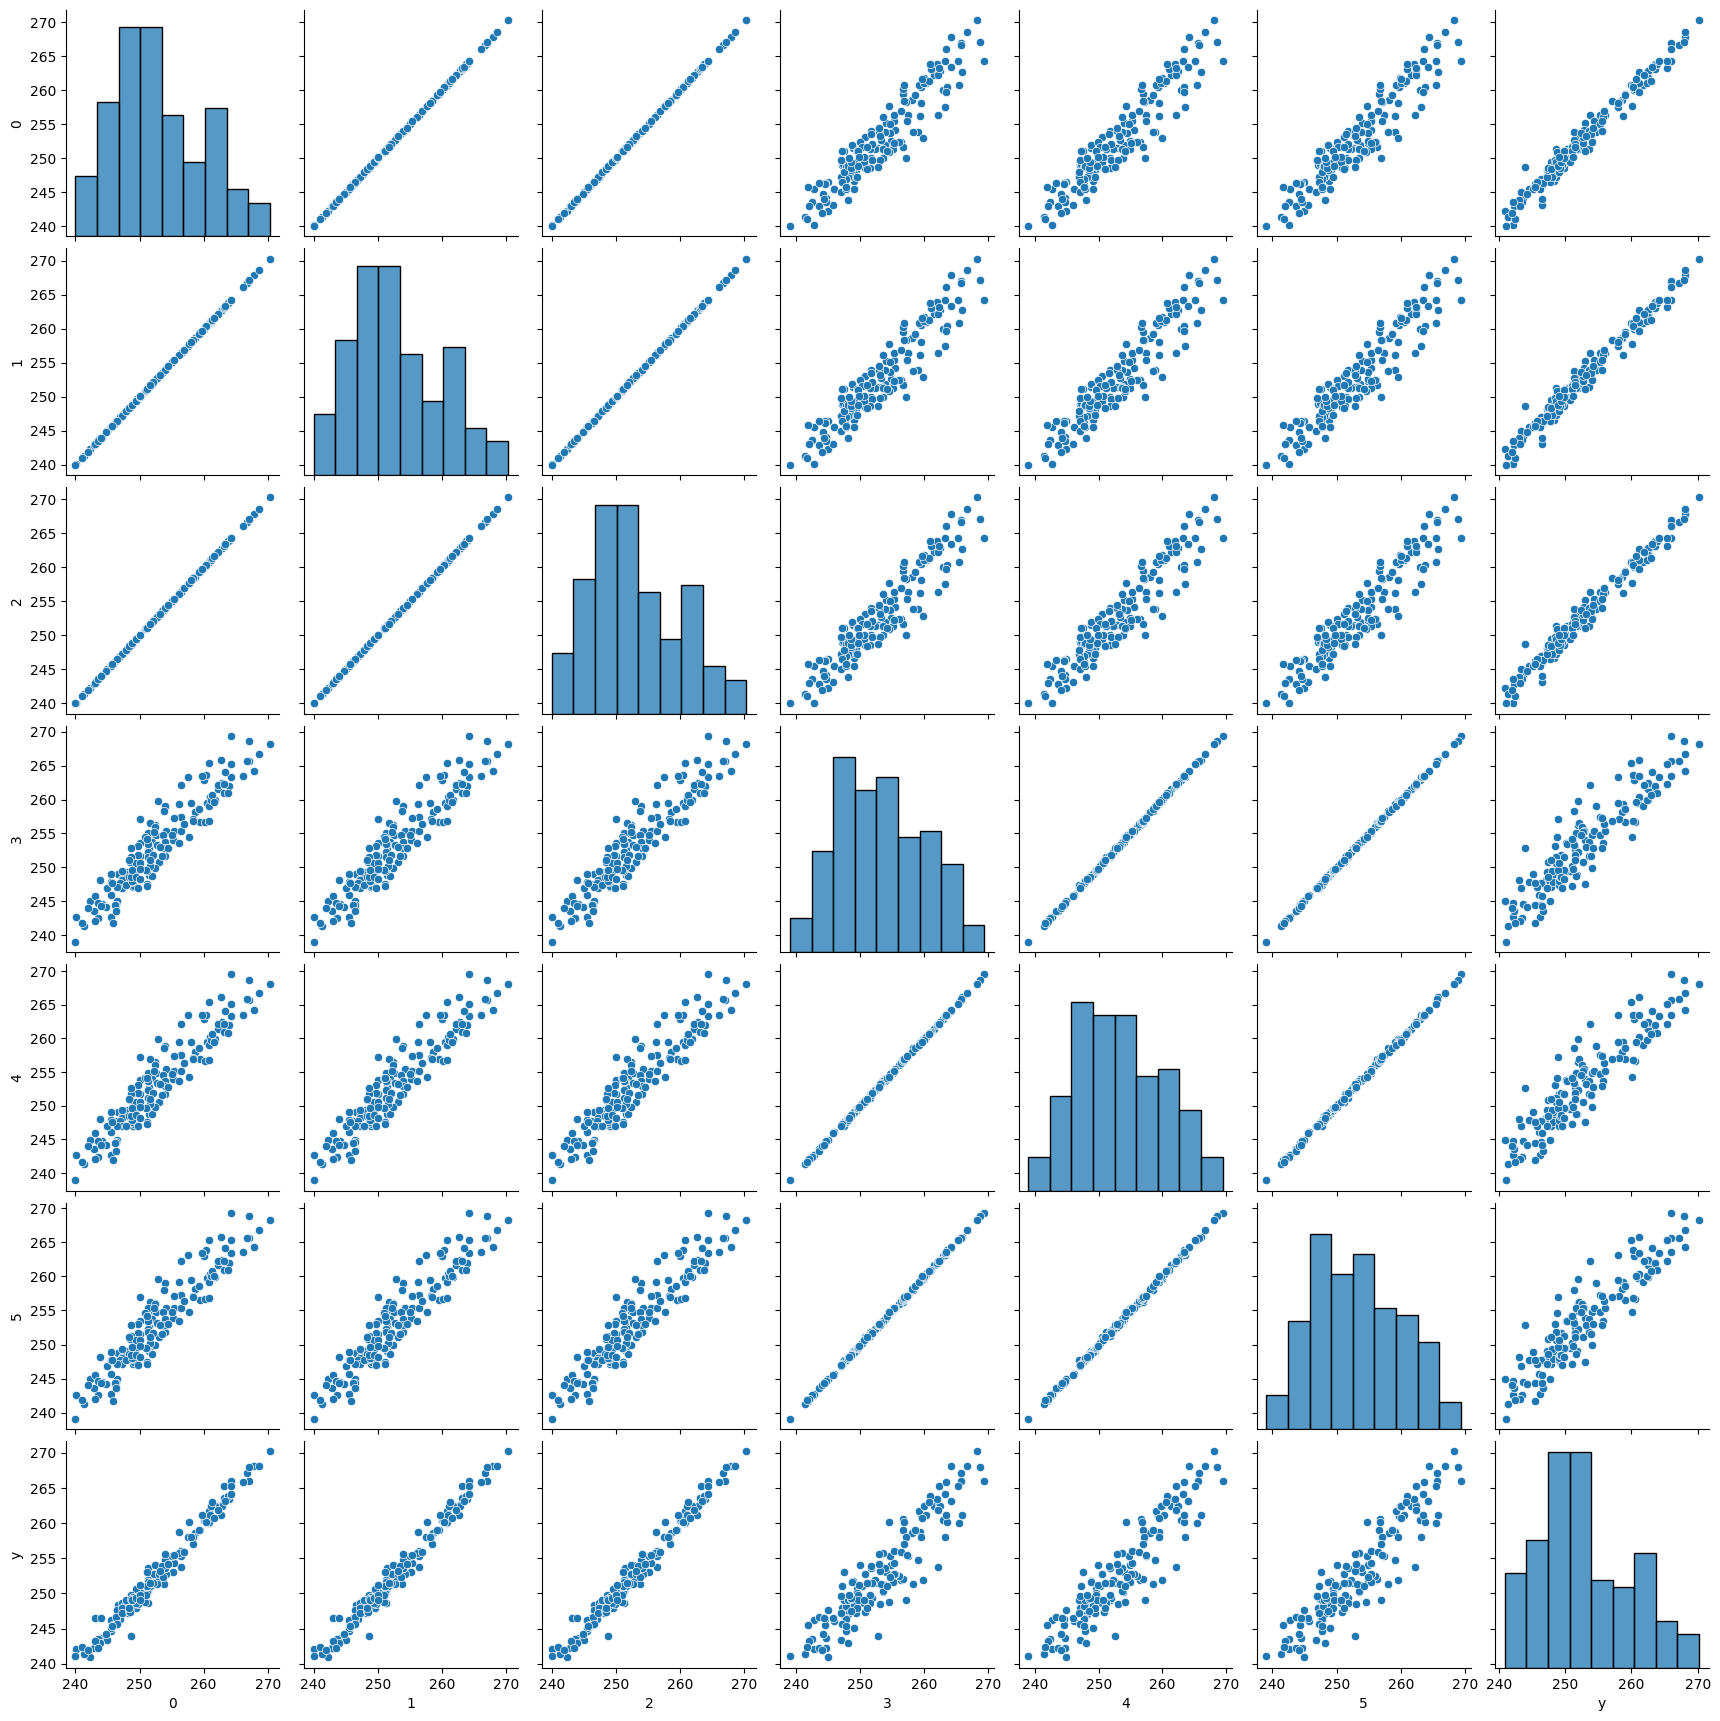

In [ ]:
sns.pairplot(df)

In [ ]:
df.corr()

,0,1,2,3,4,5,y
0,1.000000,1.000000,1.000000,0.938653,0.936901,0.940603,0.987039
1,1.000000,1.000000,1.000000,0.938653,0.936901,0.940603,0.987039
2,1.000000,1.000000,1.000000,0.938653,0.936901,0.940603,0.987039
3,0.938653,0.938653,0.938653,1.000000,0.999837,0.999845,0.919340
4,0.936901,0.936901,0.936901,0.999837,1.000000,0.999410,0.917874
5,0.940603,0.940603,0.940603,0.999845,0.999410,1.000000,0.921276
y,0.987039,0.987039,0.987039,0.919340,0.917874,0.921276,1.000000


<Axes: >

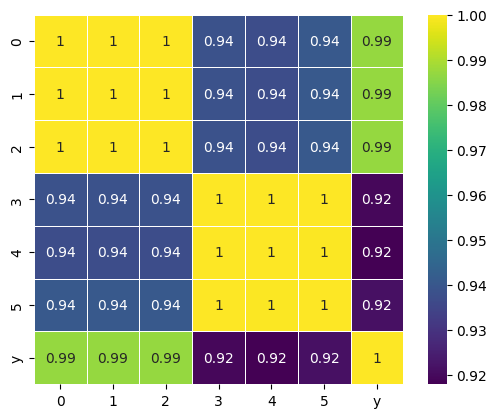

In [ ]:
sns.heatmap(df.corr(), square=True, linewidths=.5, annot=True, cmap='viridis')

In [ ]:
X

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 3, time: 151)
Coordinates:
    level    float32 1e+03
  * lat      (lat) float32 90.0 87.5
  * lon      (lon) float32 0.0 2.5 357.5
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-05-31
Data variables:
    air      (time, lat, lon) float32 250.0 250.0 250.0 ... 266.7 266.7 266.8
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2021/02 by NOAA/ESRL/PSD\nConverted to chunked, d...

In [ ]:
U, S, VT = np.linalg.svd(np.reshape(X['air'].data, newshape=(151,6)), full_matrices=False)

In [ ]:
np.sum(S[0:1]) / np.sum(S)

0.9950249

In [ ]:
df

,0,1,2,3,4,5,y
0,250.000000,250.000000,250.000000,257.100006,257.200012,256.899994,249.000000
1,250.000000,250.000000,250.000000,253.600006,253.800003,253.400009,250.199997
2,252.399994,252.399994,252.399994,256.299988,256.500000,256.100006,251.900009
3,253.899994,253.899994,253.899994,259.000000,258.899994,259.000000,254.699997
4,260.000000,260.000000,260.000000,262.899994,262.899994,263.000000,260.399994
...,...,...,...,...,...,...,...
146,266.100006,266.100006,266.100006,263.399994,263.399994,263.500000,265.899994
147,264.299988,264.299988,264.299988,265.199982,265.100006,265.399994,265.300018
148,267.100006,267.100006,267.100006,268.699982,268.600006,268.799988,268.000000
149,270.299988,270.299988,270.299988,268.199982,268.100006,268.299988,270.200012


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['y']).to_numpy()
y = df['y'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, train_size=.1)

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(7),max_iter=300, solver='adam' ,verbose=True, random_state=123, early_stopping=True)
RF = RandomForestRegressor()

In [ ]:
RF.fit(X=X_train, y=y_train)

RandomForestRegressor()

In [ ]:
model.fit(X_train,y_train)

Iteration 1, loss = 40884.19142590
Validation score: -936.519157
Iteration 2, loss = 40310.38283210
Validation score: -923.255920
Iteration 3, loss = 39738.96486331
Validation score: -910.050233
Iteration 4, loss = 39170.03517577
Validation score: -896.903758
Iteration 5, loss = 38603.66017573
Validation score: -883.817834
Iteration 6, loss = 38039.91017568
Validation score: -870.794907
Iteration 7, loss = 37478.87111314
Validation score: -857.835991
Iteration 8, loss = 36920.60939435
Validation score: -844.943072
Iteration 9, loss = 36365.19142556
Validation score: -832.117672
Iteration 10, loss = 35812.69533176
Validation score: -819.361453
Iteration 11, loss = 35263.18751922
Validation score: -806.675799
Iteration 12, loss = 34716.73439418
Validation score: -794.062395
Iteration 13, loss = 34173.39845664
Validation score: -781.522672
Iteration 14, loss = 33633.24611285
Validation score: -769.057967
Iteration 15, loss = 33096.33595656
Validation score: -756.669874
Iteration 16, loss 

MLPRegressor(early_stopping=True, hidden_layer_sizes=7, max_iter=300,
             random_state=123, verbose=True)

In [ ]:
RF.score(X=X_test, y=y_test)

0.9203565584286129

In [ ]:
model.score(X_test,y_test)

0.9336580403530317

In [ ]:
model.score(X_train,y_train)

0.9063803527169734

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# Create the MLP regressor model with two hidden layers and ReLU activation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')  # Specify the activation for the output layer
])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test) ,batch_size=32, callbacks=[early_stop])

# Predict on the test data
y_pred = model.predict(X_test)

Epoch 1/100
1/1 [==============================] - 1s 762ms/step - loss: 57883.8672 - val_loss: 54834.6719
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 56187.8281 - val_loss: 53197.5117
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 54514.7656 - val_loss: 51583.3711
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 52865.1758 - val_loss: 49992.7812
Epoch 5/100
1/1 [==============================] - 0s 58ms/step - loss: 51239.5625 - val_loss: 48426.2188
Epoch 6/100
1/1 [==============================] - 0s 55ms/step - loss: 49638.4414 - val_loss: 46884.1211
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 48062.2422 - val_loss: 45366.9570
Epoch 8/100
1/1 [==============================] - 0s 59ms/step - loss: 46511.4609 - val_loss: 43875.1250
Epoch 9/100
1/1 [==============================] - 0s 44ms/step - loss: 44986.5039 - val_loss: 42409.0352
Epoch 10/100
1/1 [===========================

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)*100

1.783919520676136

In [ ]:
model.predict()

In [ ]:
data.sel(level=1000, time=data['time.hour']==0, lat=87.5)['air'][0].values

array([257.1    , 257.2    , 257.30002, 257.4    , 257.5    , 257.6    ,
       257.6    , 257.6    , 257.6    , 257.6    , 257.5    , 257.4    ,
       257.30002, 257.2    , 257.1    , 256.9    , 256.7    , 256.5    ,
       256.30002, 256.     , 255.70001, 255.5    , 255.20001, 254.8    ,
       254.5    , 254.20001, 253.8    , 253.5    , 253.1    , 252.8    ,
       252.40001, 252.     , 251.70001, 251.3    , 250.90001, 250.6    ,
       250.3    , 249.90001, 249.6    , 249.3    , 249.     , 248.70001,
       248.5    , 248.20001, 248.     , 247.8    , 247.6    , 247.5    ,
       247.3    , 247.20001, 247.1    , 247.     , 247.     , 246.90001,
       246.90001, 246.90001, 246.90001, 246.90001, 246.90001, 246.90001,
       246.90001, 247.     , 247.     , 247.1    , 247.1    , 247.20001,
       247.20001, 247.20001, 247.3    , 247.3    , 247.3    , 247.40001,
       247.40001, 247.40001, 247.40001, 247.40001, 247.40001, 247.40001,
       247.40001, 247.40001, 247.3    , 247.3    , 

In [ ]:
lons = data.lon.data
lons

array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
       112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5,
       135. , 137.5, 140. , 142.5, 145. , 147.5, 150. , 152.5, 155. ,
       157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
       180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. ,
       202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. ,
       247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5,
       270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5, 290. ,
       292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
       315. , 317.5,

In [ ]:
lats = data.lat.data
lats

array([ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,  70. ,
        67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,  50. ,  47.5,
        45. ,  42.5,  40. ,  37.5,  35. ,  32.5,  30. ,  27.5,  25. ,
        22.5,  20. ,  17.5,  15. ,  12.5,  10. ,   7.5,   5. ,   2.5,
         0. ,  -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. ,
       -22.5, -25. , -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5,
       -45. , -47.5, -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. ,
       -67.5, -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
       -90. ], dtype=float32)

In [ ]:
pos = 0 #90
print([pos+j for j in range(0,2)])

[0, 1]


In [ ]:
pos = 71 #intermedium
print([pos+j for j in range(-1,2)])

[70, 71, 72]


In [ ]:
pos = 72 #-90
print([pos-j for j in range(0,2)])

[72, 71]


In [ ]:
pos = 0
r = 1
n_lons = len(lons)
[(pos+j)%n_lons for j in range(-r,r+1)]

[143, 0, 1]

In [ ]:
lats[60]

-60.0

In [ ]:
n_lons = len(lons)
for ind, lat in enumerate(lats):
  if ind == 0:
    print('**')
    if lat == 90:
      print(lats[[ind+j for j in range(0,2)]])
    elif lat == -90:
      print(lats[[ind-j for j in range(0,2)]])
    else:
      print(lats[[ind+j for j in range(-1,2)]])
    for ind_lon , lon in enumerate(lons):
      print(f'lat:{lat}, lon:{lon}')
      print(lons[[(ind_lon+j)%n_lons for j in range(-r,r+1)]])


**
[90.  87.5]
lat:90.0, lon:0.0
[357.5   0.    2.5]
lat:90.0, lon:2.5
[0.  2.5 5. ]
lat:90.0, lon:5.0
[2.5 5.  7.5]
lat:90.0, lon:7.5
[ 5.   7.5 10. ]
lat:90.0, lon:10.0
[ 7.5 10.  12.5]
lat:90.0, lon:12.5
[10.  12.5 15. ]
lat:90.0, lon:15.0
[12.5 15.  17.5]
lat:90.0, lon:17.5
[15.  17.5 20. ]
lat:90.0, lon:20.0
[17.5 20.  22.5]
lat:90.0, lon:22.5
[20.  22.5 25. ]
lat:90.0, lon:25.0
[22.5 25.  27.5]
lat:90.0, lon:27.5
[25.  27.5 30. ]
lat:90.0, lon:30.0
[27.5 30.  32.5]
lat:90.0, lon:32.5
[30.  32.5 35. ]
lat:90.0, lon:35.0
[32.5 35.  37.5]
lat:90.0, lon:37.5
[35.  37.5 40. ]
lat:90.0, lon:40.0
[37.5 40.  42.5]
lat:90.0, lon:42.5
[40.  42.5 45. ]
lat:90.0, lon:45.0
[42.5 45.  47.5]
lat:90.0, lon:47.5
[45.  47.5 50. ]
lat:90.0, lon:50.0
[47.5 50.  52.5]
lat:90.0, lon:52.5
[50.  52.5 55. ]
lat:90.0, lon:55.0
[52.5 55.  57.5]
lat:90.0, lon:57.5
[55.  57.5 60. ]
lat:90.0, lon:60.0
[57.5 60.  62.5]
lat:90.0, lon:62.5
[60.  62.5 65. ]
lat:90.0, lon:65.0
[62.5 65.  67.5]
lat:90.0, lon:67.5
[

In [ ]:
lats

array([ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,  70. ,
        67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,  50. ,  47.5,
        45. ,  42.5,  40. ,  37.5,  35. ,  32.5,  30. ,  27.5,  25. ,
        22.5,  20. ,  17.5,  15. ,  12.5,  10. ,   7.5,   5. ,   2.5,
         0. ,  -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. ,
       -22.5, -25. , -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5,
       -45. , -47.5, -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. ,
       -67.5, -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
       -90. ], dtype=float32)

In [ ]:
np.where(lats==-90)

(array([72]),)